In [1]:
# Import packages.
import cvxpy as cp
import numpy as np
import math
from scipy.linalg import expm
import matplotlib.pyplot as plt
from cvxpylayers.torch import CvxpyLayer

# Configure the display settings
np.set_printoptions(edgeitems=30, linewidth=125, 
    formatter=dict(float=lambda x: "%5.5f" % x))

In [2]:
# Parameter Initialization
# Background Parameter
g=[-3.7114, 0, 0]
pi = math.pi
m_dry=1505
m_wet=1905
I_sp=225
T1=930
T2=2480
n=6
phii=27*2*pi/360
alpha=5.09e-4
# alpha = cp.Parameter(name="alpha", shape=1, value=s5.09e-4)

In [3]:
# Optimal t_f and N
t_f=68
N=55
time_step=t_f/N
#Initial State
position_0=[3000, 1000, 2000]
velocity_0=[-50,10,100]
y0=np.array([position_0 + velocity_0 + [np.log(m_wet)]]).T
#print(y0, y0.shape)

In [4]:
# Define A_c Matrix
A_c1 = np.concatenate((np.zeros((3,3)), np.identity(3)), axis=1)
A_c2 = np.concatenate((A_c1, np.zeros((3,1))), axis=1)
A_c = np.concatenate((A_c2, np.zeros((4,7))), axis=0)
#print(A_c,A_c.shape)

In [5]:
# Define B_c Matrix
B_c1 = np.concatenate((np.zeros((3,3)), np.identity(3)),axis=0)
B_c2 = np.concatenate((B_c1, np.zeros((6,1))),axis=1)
B_c = np.concatenate((B_c2, np.array([[0,0,0,-alpha]])), axis=0)
#print(B_c,B_c.shape)

In [6]:
# Define A & B Matrix
"""
  Work on this later!!!
  
[A,B]=c2d(A_c,B_c,time_step);% A 7*7 ;B 7*4
"""
A = np.array([[1, 0, 0, 1.2364, 0, 0, 0],
              [0, 1, 0, 0, 1.2364, 0, 0],
              [0, 0, 1, 0, 0, 1.2364, 0],
              [0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 1]
    
])
B = np.array([[0.7643, 0, 0, 0],
              [0, 0.7643, 0, 0],
              [0, 0, 0.7643, 0],
              [1.2364, 0, 0, 0],
              [0, 1.2364, 0, 0],
              [0, 0, 1.2364, 0],
              [0, 0, 0, -alpha]
    
])
print("A=", A, A.shape)
print("B=", B, B.shape)
#print(A[:,0:3])

A= [[1.00000 0.00000 0.00000 1.23640 0.00000 0.00000 0.00000]
 [0.00000 1.00000 0.00000 0.00000 1.23640 0.00000 0.00000]
 [0.00000 0.00000 1.00000 0.00000 0.00000 1.23640 0.00000]
 [0.00000 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 1.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 1.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000]] (7, 7)
B= [[0.76430 0.00000 0.00000 0.00000]
 [0.00000 0.76430 0.00000 0.00000]
 [0.00000 0.00000 0.76430 0.00000]
 [1.23640 0.00000 0.00000 0.00000]
 [0.00000 1.23640 0.00000 0.00000]
 [0.00000 0.00000 1.23640 0.00000]
 [0.00000 0.00000 0.00000 -0.00051]] (7, 4)


In [7]:
# Matrix for State Computation
phi=np.zeros((7,7*N)) # A^k 7*7N
phi[:,0:7]=A
for k in range(2,N+1):
    phi[:,7*k-7:7*k]=A@phi[:,7*k-14:7*k-7]
#print(phi, phi.shape)

In [8]:
# # lambda parameter
# lam=np.zeros((7,4*N)) #B+AB+......A^(k-1)B 7*4N
# lam[:,0:4]=B
# for k in range(2,N+1):
#     lam[:,4*k-4:4*k]=A@lam[:,4*k-8:4*k-4]+B
# # print(lam, lam.shape)

In [9]:
# lambda parameter
lam=np.zeros((7,4*N)) #B+AB+......A^(k-1)B 7*4N
lam=B
lam_prev=B
for k in range(2,N+1):
    lam_next=A@lam_prev+B
    lam = np.concatenate([lam, lam_next], axis=1)
    lam_prev = lam_next
# print(lam, lam.shape)

In [10]:
lam[:,0:10]

array([[0.76430, 0.00000, 0.00000, 0.00000, 3.05728, 0.00000, 0.00000, 0.00000, 6.87895, 0.00000],
       [0.00000, 0.76430, 0.00000, 0.00000, 0.00000, 3.05728, 0.00000, 0.00000, 0.00000, 6.87895],
       [0.00000, 0.00000, 0.76430, 0.00000, 0.00000, 0.00000, 3.05728, 0.00000, 0.00000, 0.00000],
       [1.23640, 0.00000, 0.00000, 0.00000, 2.47280, 0.00000, 0.00000, 0.00000, 3.70920, 0.00000],
       [0.00000, 1.23640, 0.00000, 0.00000, 0.00000, 2.47280, 0.00000, 0.00000, 0.00000, 3.70920],
       [0.00000, 0.00000, 1.23640, 0.00000, 0.00000, 0.00000, 2.47280, 0.00000, 0.00000, 0.00000],
       [0.00000, 0.00000, 0.00000, -0.00051, 0.00000, 0.00000, 0.00000, -0.00102, 0.00000, 0.00000]])

In [12]:
psi=np.zeros((7*N,4*N+4)) #psi 7N*(4N+4)
psi[0:7,0:4]=B
for k in range(2,N+1):
    psi[7*k-7:7*k,:]=A@psi[7*k-14:7*k-7,:]
    psi[7*k-7:7*k,4*k-4:4*k]=B
#print(psi, psi.shape)

In [13]:
upsilon=np.zeros((4*N,4*N+4)) #upsilon 4N*(4N+4)
for k in range(1,N+1):
    upsilon[4*k-4:4*k,4*k-4:4*k]=np.identity(4)
#print(upsilon, upsilon.shape)


In [14]:
# Matrix for Optimal Computation
Z0 = np.zeros((N+1,1))
for k in range(N+1):
    Z0[k,0]=np.log(m_wet-alpha*n*T2*math.cos(phii)*time_step*k) #(N+1)*1
#print(Z0,Z0.shape)
#print(Z0[7,0])

mu_1 = np.zeros((1,N+1))
mu_2 = np.zeros((1,N+1))
for k in range(N+1):
    mu_1[0,k]=n*T1*math.cos(phii)*np.exp(-Z0[k,0]) #1*(N+1)
    mu_2[0,k]=n*T2*math.cos(phii)*np.exp(-Z0[k,0]) #1*(N+1)
#print(mu_1, mu_1.shape)
#print(mu_2, mu_2.shape)   

In [15]:
epsilon_k=np.zeros((7,N))
for k in range(0,N):
    temp = phi[:,7*k:7*(k+1)]@y0+lam[:,4*k:4*(k+1)]@np.array([g + [0]]).T
    #print(temp.shape)
    epsilon_k[:,k]=temp[:,0]
#print(epsilon_k, epsilon_k.shape)

In [16]:
e_sigma = np.array([0,0,0,1])
#E = np.concatenate((np.identity(6), np.zeros((6,1))), axis=1)
F = np.concatenate((np.zeros(6), np.ones(1)), axis=None).reshape((1,7))
E_u = np.concatenate((np.identity(3), np.zeros((3,1))), axis=1)
#print(F,F.shape)

In [17]:
omega=np.zeros((1,4*N))  #1*4N
for k in range(0,N):
    omega[0,4*k:4*(k+1)]=e_sigma
omega=time_step*omega
#print(omega, omega.shape)

In [18]:
# Define and solve the CVXPY problem.
eta = cp.Variable((4*N+4,1))
obj = cp.Minimize(omega@eta[0:4*N,0])


In [19]:
#  Final height constraint
m1 = np.concatenate((np.identity(3), np.zeros((3,4))), axis=1)
m2 = np.concatenate((np.zeros((4,3)), np.zeros((4,4))), axis=1)
m = np.concatenate((m1, m2), axis=0)
h_const = [m@(epsilon_k[:,N-1].reshape((7,1))+psi[7*N-7:7*N,:]@eta)==np.zeros((7,1))]

In [20]:
#  Final velocity constraint
v_const = [
    np.array([[0, 0, 0, 1, 0, 0, 0]])@(epsilon_k[:,N-1].reshape((7,1))+psi[7*N-7:7*N,:]@eta)==0,
    np.array([[0, 0, 0, 0, 1, 0, 0]])@(epsilon_k[:,N-1].reshape((7,1))+psi[7*N-7:7*N,:]@eta)==0,
    np.array([[0, 0, 0, 0, 0, 1, 0]])@(epsilon_k[:,N-1].reshape((7,1))+psi[7*N-7:7*N,:]@eta)==0,
]


In [21]:
# Convexified Thrust Constraint
#Conv_const = []
#for k in range(N):
#    Conv_const.append(cp.norm(E_u@upsilon[4*k:4*k+4,:]@eta,2) <= e_sigma@upsilon[4*k:4*k+4,:]@eta) 
#    #cp.norm(E_u@upsilon[4*k:4*k+4,:]@eta,2)<=e_sigma@upsilon[4*k:4*k+4,:]@eta
Conv_const = [
      cp.SOC(e_sigma@upsilon[4*k:4*k+4,:]@eta, E_u@upsilon[4*k:4*k+4,:]@eta) for k in range(N)
      # cp.norm(E_u @ upsilon[4*k+1:4*k+4+1,:] @ eta, 2) <= e_sigma @ upsilon[4*k+1:4*k+4+1,:]@eta for k in range(0,N-1) # ?
]

In [22]:

# thrust constraints
thr_const = [mu_1[0,0]*(1-(F@y0-Z0[0])+0.5*(F@y0-Z0[0])**2)<=e_sigma@upsilon[0:4,:]@eta,
            e_sigma@upsilon[0:4,:]@eta<=mu_2[0,0]*(1-(F@y0-Z0[0]))]
  
for k in range(0,N):
    thr_const.append(mu_1[0,k+1]*(1-(F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)-Z0[k+1,0])+0.5*(F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)-Z0[k+1,0])**2)<=e_sigma@upsilon[4*k:4*k+4,:]@eta)
    thr_const.append(e_sigma@upsilon[4*k:4*k+4,:]@eta<=mu_2[0,k+1]*(1-(F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)-Z0[k+1,0])))


In [23]:
# Fuel mass constraints
f_const = []
for k in range(0,N):
    f_const.append(F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)<=np.log(m_wet-alpha*n*T1*math.cos(phii)*time_step*(k+1)))
    f_const.append(np.log(m_wet-alpha*n*T2*math.cos(phii)*time_step*(k+1))<=F.reshape((1,7))@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta))


In [24]:
# Cone constraints
cone_const = [cp.norm(np.array([[0, 1, 0],[0, 0, 1]])@np.concatenate((np.identity(3),np.zeros((3,4))),axis=1)@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta),2)+np.array([[-0.268, 0, 0, 0, 0, 0, 0]])@(epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta)<=0]


In [25]:
socp_constraints =  Conv_const + thr_const + f_const + h_const + v_const + cone_const

prob = cp.Problem(obj, socp_constraints)
print(prob.parameters())
prob.solve()
print(obj.value)
print(prob.status)

[]
421.4635709035776
optimal


In [26]:
#     Output Information
# Converting output into manageable format
display_position = np.zeros((3,N+1))
display_velocity = np.zeros((3,N+1))
display_netthrust = np.zeros((3,N+1))
display_thrust = np.zeros((3,N+1))
display_allthrust = np.zeros((1,N+1))
display_allvelocity = np.zeros((1,N+1))
display_position[0:3, 0] = position_0
display_velocity[0:3, 0] = velocity_0
mass = np.zeros((1,N+1))
mass[0] = m_wet

In [27]:
for k in range(0,N):
    v = (epsilon_k[:,k].reshape((7,1))+psi[7*k:7*(k+1),:]@eta.value)
    display_position[:,k+1] = (np.concatenate((np.identity(3), np.zeros((3,4))), axis=1)@v).reshape((3,))
    temp = np.concatenate((np.zeros((3,3)), np.identity(3)), axis=1)
    display_velocity[:,k+1] = (np.concatenate((temp, np.zeros((3,1))), axis=1)@v).reshape(3,)
    mass[0,k+1] = np.array([[0, 0, 0, 0, 0, 0, 1]])@v
    mass[0,k+1] = np.exp(mass[0,k+1])

for k in range(0,N):
    display_netthrust[:,k+1] = (np.concatenate((np.identity(3), np.zeros((3,1))), axis=1)@(upsilon[4*k:4*k+4,:]@eta.value)).reshape(3,)
    display_thrust[:,k+1] = display_netthrust[:,k+1]
    display_netthrust[:,k+1] = display_netthrust[:,k+1]*mass[0,k+1]
    #display_allthrust[0,k+1] = cp.norm(display_thrust[0:3,k+1],2)*mass[0,k+1]
    #display_allvelocity[0,k+1] = cp.norm(display_velocity[0:3,k+1],2)


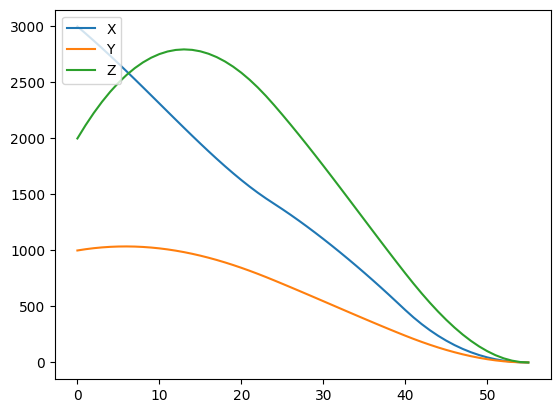

In [28]:
plt.plot(display_position[0,:],label="X")
plt.plot(display_position[1,:],label="Y")
plt.plot(display_position[2,:],label="Z")
plt.legend(loc="upper left")

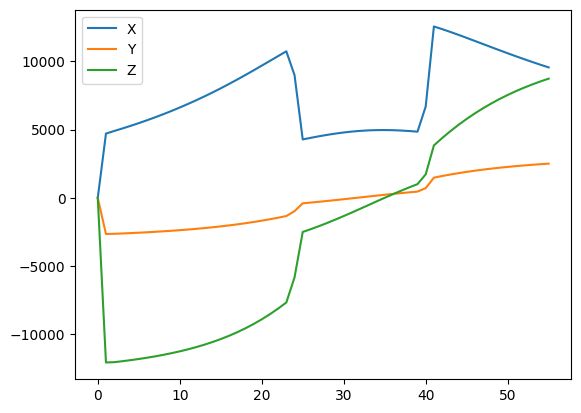

In [29]:
plt.plot(display_netthrust[0,:],label="X")
plt.plot(display_netthrust[1,:],label="Y")
plt.plot(display_netthrust[2,:],label="Z")
plt.legend(loc="upper left")

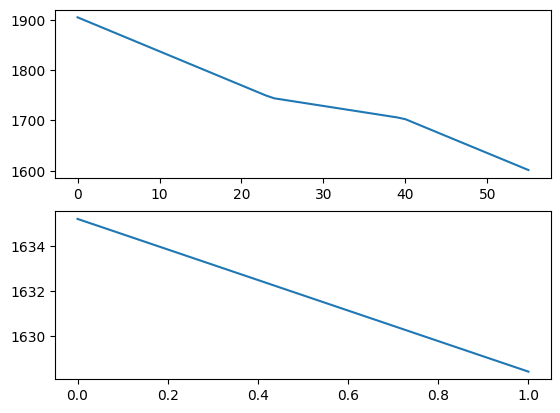

In [30]:
m1 = plt.subplot(2,1,1)
m2 = plt.subplot(2,1,2)
m1.plot(mass[0,:],label="Z")

m2.plot(mass[0,50:52],label="Z")